In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report

import scipy.spatial.distance
from luciferml.supervised import classification as cls

df = pd.read_excel (r'C:\Users\stugr\OneDrive\Masaüstü\telco_customer_churn.xlsx')
print (df)

      CustomerID  Count        Country       State          City  Zip Code  \
0     3668-QPYBK      1  United States  California   Los Angeles     90003   
1     9237-HQITU      1  United States  California   Los Angeles     90005   
2     9305-CDSKC      1  United States  California   Los Angeles     90006   
3     7892-POOKP      1  United States  California   Los Angeles     90010   
4     0280-XJGEX      1  United States  California   Los Angeles     90015   
...          ...    ...            ...         ...           ...       ...   
7038  2569-WGERO      1  United States  California       Landers     92285   
7039  6840-RESVB      1  United States  California      Adelanto     92301   
7040  2234-XADUH      1  United States  California         Amboy     92304   
7041  4801-JZAZL      1  United States  California  Angelus Oaks     92305   
7042  3186-AJIEK      1  United States  California  Apple Valley     92308   

                    Lat Long   Latitude   Longitude  Gender  ..

In [2]:
#eliminate the features that might not related to our case
nn_columns = ["Count", "Country", "State", "City","Zip Code", "Lat Long", "Latitude",
            "Longitude", "Churn Label", "Churn Score","CLTV","Churn Reason"]
data = df.drop(nn_columns, axis=1)

In [3]:
#total charges feature contains float data so it should be changed
data.dtypes

CustomerID            object
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Value            int64
dtype: object

In [4]:
#Ttotal charges feature needs to be numeric rather than categorical
data["Total Charges"] = pd.to_numeric(data["Total Charges"], errors='coerce')
data.isnull().sum()

CustomerID            0
Gender                0
Senior Citizen        0
Partner               0
Dependents            0
Tenure Months         0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges       0
Total Charges        11
Churn Value           0
dtype: int64

In [5]:
#drop the rows which have missing values
data.dropna(inplace = True)
data.columns = data.columns.str.lower().str.replace(' ','_')

In [6]:
#data is ready with 7032 rows and 21 feature including label as "churn value"
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerid         7032 non-null   object 
 1   gender             7032 non-null   object 
 2   senior_citizen     7032 non-null   object 
 3   partner            7032 non-null   object 
 4   dependents         7032 non-null   object 
 5   tenure_months      7032 non-null   int64  
 6   phone_service      7032 non-null   object 
 7   multiple_lines     7032 non-null   object 
 8   internet_service   7032 non-null   object 
 9   online_security    7032 non-null   object 
 10  online_backup      7032 non-null   object 
 11  device_protection  7032 non-null   object 
 12  tech_support       7032 non-null   object 
 13  streaming_tv       7032 non-null   object 
 14  streaming_movies   7032 non-null   object 
 15  contract           7032 non-null   object 
 16  paperless_billing  7032 

In [7]:
#checking for duplicates for customers
dups = data[data.duplicated(subset=['customerid'])==True]
print(f'{dups.shape[0]} duplicate CustomerIDs found')

data = data.drop("customerid", axis=1)

0 duplicate CustomerIDs found


In [8]:
#data cleaning

# check value counts by column for object datatypes
col_list = ['gender', 'senior_citizen', 'partner', 'dependents', 
            'phone_service', 'multiple_lines', 'internet_service', 
            'online_security', 'online_backup', 'device_protection', 
            'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 
            'paperless_billing', 'payment_method', 'churn_value']

for col in col_list:
     print(f'\nValue Counts | column = {col}')
     print(data[col].value_counts(normalize=True, dropna=False))


Value Counts | column = gender
Male      0.504693
Female    0.495307
Name: gender, dtype: float64

Value Counts | column = senior_citizen
No     0.8376
Yes    0.1624
Name: senior_citizen, dtype: float64

Value Counts | column = partner
No     0.517491
Yes    0.482509
Name: partner, dtype: float64

Value Counts | column = dependents
No     0.769625
Yes    0.230375
Name: dependents, dtype: float64

Value Counts | column = phone_service
Yes    0.903299
No     0.096701
Name: phone_service, dtype: float64

Value Counts | column = multiple_lines
No                  0.481371
Yes                 0.421928
No phone service    0.096701
Name: multiple_lines, dtype: float64

Value Counts | column = internet_service
Fiber optic    0.440273
DSL            0.343572
No             0.216155
Name: internet_service, dtype: float64

Value Counts | column = online_security
No                     0.497298
Yes                    0.286547
No internet service    0.216155
Name: online_security, dtype: float64



In [9]:
#report about data with unique values of features and types
def report(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []
    
    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())
    
    return pd.DataFrame({'Column': col, 'd_type': d_type, 'unique_sample': uniques, 'n_uniques': n_uniques})

report(data)

,Column,d_type,unique_sample,n_uniques
0,gender,object,"[Male, Female]",2
1,senior_citizen,object,"[No, Yes]",2
2,partner,object,"[No, Yes]",2
3,dependents,object,"[No, Yes]",2
4,tenure_months,int64,"[2, 8, 28, 49, 10]",72
5,phone_service,object,"[Yes, No]",2
6,multiple_lines,object,"[No, Yes, No phone service]",3
7,internet_service,object,"[DSL, Fiber optic, No]",3
8,online_security,object,"[Yes, No, No internet service]",3
9,online_backup,object,"[Yes, No, No internet service]",3


In [10]:
dt = data.copy()

In [11]:
#multiple answered categorical variables changed by OneHotEncoding

def one_hot_encoding(dt):
    categoricals = ['gender', 'internet_service', 'contract', 'payment_method']
    
    dt_ohe = pd.get_dummies(dt[categoricals], drop_first=False, dtype=int)
    
    dt = pd.concat([dt, dt_ohe], axis=1)
    dt.drop(categoricals, axis=1, inplace=True)
    
    return dt

In [12]:
#yes/no categorical variables turning into boolean variables

def binary_trans(dt):
    
    bool_list = ['senior_citizen', 'partner', 'dependents', 'phone_service', 
                 'multiple_lines', 'online_security', 
                 'online_backup', 'device_protection', 'tech_support', 
                 'streaming_tv', 'streaming_movies', 'paperless_billing']
    
    for col in bool_list:
        dt.replace({col : { 'Yes' : 1, 'No' : 0, 'No phone service' : 0,
                           'No internet service' : 0}}, inplace=True)
    
    return dt

In [13]:
dt = binary_trans(dt)

In [14]:
dt = one_hot_encoding(dt)

In [15]:
#train and split

y = dt['churn_value']
x = dt.drop(columns=['churn_value'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x,y,train_size=0.8, random_state = 10)

In [16]:
X_train.describe()

#Notes on Describe

#Demographics: 16% seniors, 48% w/ partner, 23% w/ dependents, 50% male
#Tenure: Mean is 32 months, Upper 25% 55 months
#Product: Phone 90%, Multi-line 42%, Security 29%, Backup 34%, Protection 34%, Support 29%, Streaming 38%, DSL 34%, Fiber 44%
#Contract: 20% 1yr, 24% 2yr, 55% month-to-month
#Billing: Paperless 59%, CC Auto 22%, echeck 34%, mail 23%, bank transfer 22%
#Monthly Charges: Average $65, Median \$70, Range $18-119

,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,...,internet_service_DSL,internet_service_Fiber optic,internet_service_No,contract_Month-to-month,contract_One year,contract_Two year,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check
count,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,...,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000
mean,0.161956,0.483733,0.229333,32.363022,0.897778,0.418489,0.285867,0.340978,0.342222,0.288533,...,0.344000,0.438578,0.217422,0.554489,0.207822,0.237689,0.216178,0.216711,0.335289,0.231822
std,0.368443,0.499780,0.420441,24.533741,0.302967,0.493355,0.451866,0.474080,0.474496,0.453121,...,0.475083,0.496257,0.412529,0.497066,0.405785,0.425705,0.411674,0.412041,0.472133,0.422034
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
#LOGISTIC REGRESSION

In [18]:
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)
accuracy_lr = lr_model.score(X_test,y_test)
print("Logistic Regression accuracy is :",accuracy_lr)

Logistic Regression accuracy is : 0.8002842928216063


C:\Users\stugr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
lr_pred= lr_model.predict(X_test)
report = classification_report(y_test,lr_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1032
           1       0.64      0.56      0.60       375

    accuracy                           0.80      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.79      0.80      0.80      1407



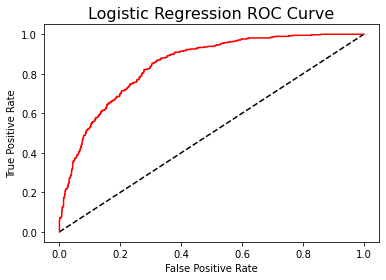

In [20]:
#plotting ROC curve for logistic regression

y_pred_prob = lr_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr, tpr, label='Logistic Regression',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve',fontsize=16)
plt.show();

In [22]:
metrics.auc(fpr, tpr)

0.8461614987080104

In [23]:
#RANDOM FOREST

rf_model = RandomForestClassifier(n_estimators=500 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
rf_model.fit(X_train, y_train)

# Make predictions
test_pred = rf_model.predict(X_test)
report = classification_report(y_test,test_pred)
print (report)

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1032
           1       0.64      0.47      0.54       375

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407



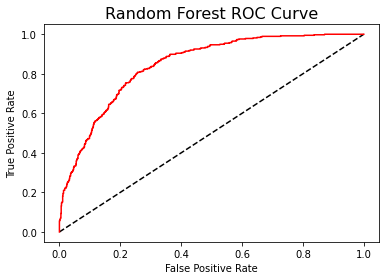

In [24]:
y_rf_prob = rf_model.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_rf_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve',fontsize=16)
plt.show();

In [26]:
#DECISION TREE

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,y_train)

dt_pred = dt_model.predict(X_test)
#accuracy_dt = dt_model.score(X_test,y_test)
#print("Decision Tree accuracy is :",accuracy_dt)
report = classification_report(y_test,dt_pred)
print (report)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1032
           1       0.51      0.54      0.53       375

    accuracy                           0.74      1407
   macro avg       0.67      0.68      0.67      1407
weighted avg       0.75      0.74      0.74      1407



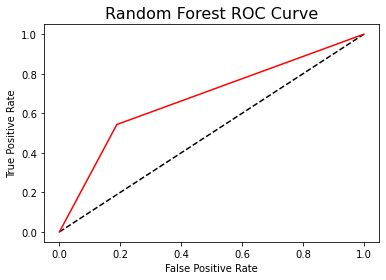

In [27]:
y_rf_prob = dt_model.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_rf_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve',fontsize=16)
plt.show();

In [110]:
#ADABOOST CLASSIFIER

ada_model = AdaBoostClassifier()
ada_model.fit(X_train,y_train)
ada_preds = ada_model.predict(X_test)

report = classification_report(y_test,ada_preds)
print (report)


              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1032
           1       0.63      0.53      0.58       375

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



In [111]:
#GRADIENT BOOSTING CLASSIFIER

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc_pred = gbc.predict(X_test)

report = classification_report(y_test,gbc_pred)
print (report)


              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1032
           1       0.63      0.53      0.58       375

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.79      0.79      1407



In [112]:
#SUPPORT VECTOR MACHINES

svm_model = SVC(random_state = 1)
svm_model.fit(X_train,y_train)
svm_pred = svm_model.predict(X_test)

report = classification_report(y_test,svm_pred)
print (report)


              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1032
           1       0.00      0.00      0.00       375

    accuracy                           0.73      1407
   macro avg       0.37      0.50      0.42      1407
weighted avg       0.54      0.73      0.62      1407



C:\Users\stugr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Started Predictor 

Checking if labels or features are categorical! [*]

Features and labels are not categorical [ ✓ ]

Checking for Sparse Matrix [*]

Splitting Data into Train and Validation Sets [*]

Splitting Done [ ✓ ]

Scaling Training and Test Sets [*]

Scaling Done [ ✓ ]

Training Logistic Regression on Training Set [*]

Model Training Done [ ✓ ]

Predicting Data [*]

Data Prediction Done [ ✓ ]

Making Confusion Matrix [*]
[[914  98]
 [166 229]]


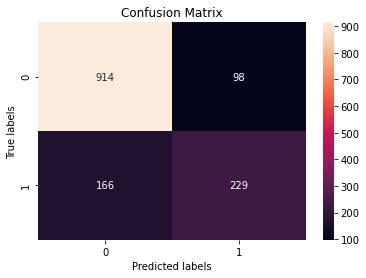

Confusion Matrix Done [ ✓ ]

Evaluating Model Performance [*]
Validation Accuracy is : 0.8123667377398721
Evaluating Model Performance [ ✓ ]

Applying K-Fold Cross Validation [*]
Accuracy: 81.05 %
Standard Deviation: 2.07 %
K-Fold Cross Validation [ ✓ ]

Complete [ ✓ ]

Time Elapsed :  0.414841890335083 seconds 



In [29]:
'''
- 'lr' : 'Logistic Regression',
 - 'svm': 'Support Vector Machine',
 - 'knn': 'K-Nearest Neighbours',
 - 'dt' : 'Decision Trees',
 - 'nb' : 'Naive Bayes',
 - 'rfc': 'Random Forest Classifier',
 - 'xgb': 'XGBoost Classifier',
 - 'ann': 'Artificical Neural Network',
 '''

classifier_name,accuracy = cls.Classification(predictor = 'lr').predict(x, y)

In [30]:
#function that extracts churn data points to examine further analysis

def churn_data(X_test, lr_pred):
    lr_data = pd.DataFrame(lr_pred)
    X_test.reset_index(drop=True, inplace=True)
    X_test = X_test.assign(churn_labels = lr_data)
    rslt_df = X_test[X_test['churn_labels'] == 1]
    dd = rslt_df.drop(columns = "churn_labels")
    
    return dd

In [31]:
new_data = churn_data(X_test,lr_pred)

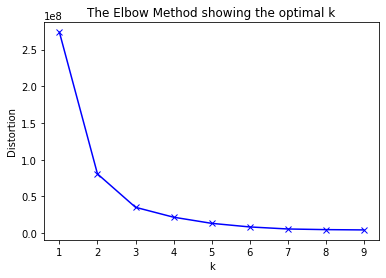

In [32]:
#applying elbow method to find optimal # of clusters

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(new_data)
    kmeanModel.fit(new_data)
    distortions.append(sum(np.min(scipy.spatial.distance.cdist(new_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1))**2 / new_data.shape[0])
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [39]:
#implementation of k-means with 3 clusters

kmeans = KMeans(n_clusters=3, random_state=0)
label = kmeans.fit_predict(new_data)
print(label)

[0 2 0 2 0 2 0 2 2 2 2 2 0 2 2 0 2 0 2 0 0 0 0 2 0 1 2 1 2 2 0 0 0 0 2 2 0
 2 0 0 2 2 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 2 2 2 1 0 2 0 0 0 0 0 0 0 2 2 1 0
 0 0 2 0 0 0 0 0 0 2 0 0 0 2 0 1 0 2 0 0 0 0 0 2 0 0 0 2 0 0 2 0 0 2 0 0 2
 0 0 0 1 1 0 0 2 0 0 0 0 0 0 0 0 2 2 0 0 1 2 1 0 0 2 0 0 0 0 0 0 1 0 0 2 0
 2 0 0 0 0 0 2 2 2 1 0 0 0 2 2 2 0 0 0 2 1 0 0 0 0 0 1 1 0 0 0 0 0 0 2 2 0
 0 0 0 1 0 0 0 0 0 0 0 0 2 0 2 2 0 0 2 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 2 2 1 2 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 2 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 2 1 0 2 0 0 0 0 0 2 2 2 0 0 0 0 0 0 2 0 2 1
 0 0 0 2 2 0 2 0 0 2 0 0 0 0 2 1 0 0 0 0 2 0 0 0 0 0 0 0 2 0]


In [40]:
#adding clusters labels to the data

km_data = new_data.copy()
km_data = km_data.assign(cluster_label = label)

In [41]:
#pca implementation to visualize the data in 2d platform

from sklearn.decomposition import PCA

pca = PCA(n_components=3).fit(km_data)
pca_2d = pca.transform(km_data)

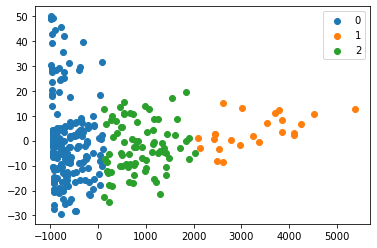

In [42]:
#Getting unique labels

u_labels = np.unique(label)

#plotting the results:

for i in u_labels:
    plt.scatter(pca_2d[label == i , 0] , pca_2d[label == i , 1] , label = i)
plt.legend()
plt.show()

In [43]:
#seperate customers by segmentation into 3 groups

c1 = km_data[km_data['cluster_label'] == 0]
c2 = km_data[km_data['cluster_label'] == 1]
c3 = km_data[km_data['cluster_label'] == 2]

In [44]:
c1.describe()

,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,...,internet_service_Fiber optic,internet_service_No,contract_Month-to-month,contract_One year,contract_Two year,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,cluster_label
count,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,...,221.000000,221.0,221.0,221.0,221.0,221.000000,221.000000,221.000000,221.000000,221.0
mean,0.244344,0.199095,0.004525,4.574661,0.918552,0.416290,0.045249,0.162896,0.190045,0.099548,...,0.814480,0.0,1.0,0.0,0.0,0.076923,0.072398,0.742081,0.108597,0.0
std,0.430673,0.400226,0.067267,3.923135,0.274143,0.494062,0.208321,0.370109,0.393227,0.300075,...,0.389602,0.0,0.0,0.0,0.0,0.267074,0.259734,0.438482,0.311840,0.0
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.0,1.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0
75%,0.000000,0.000000,0.000000,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.0,1.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,1.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.0


In [46]:
print(c1.columns)

Index(['senior_citizen', 'partner', 'dependents', 'tenure_months',
       'phone_service', 'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges',
       'gender_Female', 'gender_Male', 'internet_service_DSL',
       'internet_service_Fiber optic', 'internet_service_No',
       'contract_Month-to-month', 'contract_One year', 'contract_Two year',
       'payment_method_Bank transfer (automatic)',
       'payment_method_Credit card (automatic)',
       'payment_method_Electronic check', 'payment_method_Mailed check',
       'cluster_label'],
      dtype='object')


In [50]:
#basic data stats for cluster 1

# check value counts by column for object datatypes
col_list = ['senior_citizen', 'partner', 'dependents', 'tenure_months',
       'phone_service', 'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges',
       'gender_Female', 'gender_Male', 'internet_service_DSL',
       'internet_service_Fiber optic', 'internet_service_No',
       'contract_Month-to-month', 'contract_One year', 'contract_Two year',
       'payment_method_Bank transfer (automatic)',
       'payment_method_Credit card (automatic)',
       'payment_method_Electronic check', 'payment_method_Mailed check']

for col in col_list:
     print(f'\nValue Counts | column = {col}')
     print(c1[col].value_counts(normalize=True, dropna=False))


Value Counts | column = senior_citizen
0    0.755656
1    0.244344
Name: senior_citizen, dtype: float64

Value Counts | column = partner
0    0.800905
1    0.199095
Name: partner, dtype: float64

Value Counts | column = dependents
0    0.995475
1    0.004525
Name: dependents, dtype: float64

Value Counts | column = tenure_months
1     0.303167
2     0.113122
3     0.113122
4     0.081448
9     0.067873
8     0.058824
5     0.058824
7     0.049774
6     0.040724
10    0.031674
12    0.027149
13    0.018100
11    0.013575
14    0.009050
19    0.004525
16    0.004525
22    0.004525
Name: tenure_months, dtype: float64

Value Counts | column = phone_service
1    0.918552
0    0.081448
Name: phone_service, dtype: float64

Value Counts | column = multiple_lines
0    0.58371
1    0.41629
Name: multiple_lines, dtype: float64

Value Counts | column = online_security
0    0.954751
1    0.045249
Name: online_security, dtype: float64

Value Counts | column = online_backup
0    0.837104
1    0.1628

In [48]:
c2.describe()

,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,...,internet_service_Fiber optic,internet_service_No,contract_Month-to-month,contract_One year,contract_Two year,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,cluster_label
count,24.000000,24.000000,24.0,24.000000,24.0,24.0,24.000000,24.000000,24.000000,24.0,...,24.0,24.0,24.0,24.0,24.0,24.000000,24.000000,24.000000,24.0,24.0
mean,0.458333,0.458333,0.0,42.625000,1.0,1.0,0.041667,0.541667,0.625000,0.0,...,1.0,0.0,1.0,0.0,0.0,0.166667,0.041667,0.791667,0.0,1.0
std,0.508977,0.508977,0.0,7.750526,0.0,0.0,0.204124,0.508977,0.494535,0.0,...,0.0,0.0,0.0,0.0,0.0,0.380693,0.204124,0.414851,0.0,0.0
min,0.000000,0.000000,0.0,32.000000,1.0,1.0,0.000000,0.000000,0.000000,0.0,...,1.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0
25%,0.000000,0.000000,0.0,36.000000,1.0,1.0,0.000000,0.000000,0.000000,0.0,...,1.0,0.0,1.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,1.0
50%,0.000000,0.000000,0.0,42.500000,1.0,1.0,0.000000,1.000000,1.000000,0.0,...,1.0,0.0,1.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,1.0
75%,1.000000,1.000000,0.0,48.250000,1.0,1.0,0.000000,1.000000,1.000000,0.0,...,1.0,0.0,1.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,1.0
max,1.000000,1.000000,0.0,60.000000,1.0,1.0,1.000000,1.000000,1.000000,0.0,...,1.0,0.0,1.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.0


In [51]:
#basic data stats for cluster 2

for col in col_list:
     print(f'\nValue Counts | column = {col}')
     print(c2[col].value_counts(normalize=True, dropna=False))


Value Counts | column = senior_citizen
0    0.541667
1    0.458333
Name: senior_citizen, dtype: float64

Value Counts | column = partner
0    0.541667
1    0.458333
Name: partner, dtype: float64

Value Counts | column = dependents
0    1.0
Name: dependents, dtype: float64

Value Counts | column = tenure_months
32    0.083333
42    0.083333
33    0.083333
49    0.083333
36    0.083333
37    0.083333
46    0.083333
35    0.041667
39    0.041667
60    0.041667
43    0.041667
54    0.041667
47    0.041667
48    0.041667
50    0.041667
53    0.041667
44    0.041667
Name: tenure_months, dtype: float64

Value Counts | column = phone_service
1    1.0
Name: phone_service, dtype: float64

Value Counts | column = multiple_lines
1    1.0
Name: multiple_lines, dtype: float64

Value Counts | column = online_security
0    0.958333
1    0.041667
Name: online_security, dtype: float64

Value Counts | column = online_backup
1    0.541667
0    0.458333
Name: online_backup, dtype: float64

Value Counts | 

In [52]:
c3.describe()

,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,...,internet_service_Fiber optic,internet_service_No,contract_Month-to-month,contract_One year,contract_Two year,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,cluster_label
count,81.000000,81.000000,81.0,81.000000,81.0,81.000000,81.000000,81.000000,81.000000,81.000000,...,81.0,81.0,81.0,81.0,81.0,81.000000,81.000000,81.000000,81.000000,81.0
mean,0.382716,0.456790,0.0,21.234568,1.0,0.679012,0.135802,0.308642,0.296296,0.111111,...,1.0,0.0,1.0,0.0,0.0,0.259259,0.086420,0.604938,0.049383,2.0
std,0.489078,0.501233,0.0,5.566129,0.0,0.469765,0.344713,0.464811,0.459468,0.316228,...,0.0,0.0,0.0,0.0,0.0,0.440959,0.282734,0.491910,0.218016,0.0
min,0.000000,0.000000,0.0,11.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2.0
25%,0.000000,0.000000,0.0,18.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2.0
50%,0.000000,0.000000,0.0,21.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,2.0
75%,1.000000,1.000000,0.0,24.000000,1.0,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.0,0.0,1.0,0.0,0.0,1.000000,0.000000,1.000000,0.000000,2.0
max,1.000000,1.000000,0.0,38.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,0.0,1.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,2.0


In [64]:
#basic data stats for cluster 3

for col in col_list:
     print(f'\nValue Counts | column = {col}')
     print(c3[col].value_counts(normalize=True, dropna=False))


Value Counts | column = senior_citizen
0    0.617284
1    0.382716
Name: senior_citizen, dtype: float64

Value Counts | column = partner
0    0.54321
1    0.45679
Name: partner, dtype: float64

Value Counts | column = dependents
0    1.0
Name: dependents, dtype: float64

Value Counts | column = tenure_months
18    0.098765
21    0.098765
20    0.086420
24    0.086420
17    0.074074
13    0.074074
26    0.061728
22    0.061728
30    0.049383
19    0.049383
16    0.037037
27    0.037037
23    0.024691
15    0.024691
29    0.024691
12    0.024691
25    0.024691
38    0.012346
35    0.012346
31    0.012346
32    0.012346
11    0.012346
Name: tenure_months, dtype: float64

Value Counts | column = phone_service
1    1.0
Name: phone_service, dtype: float64

Value Counts | column = multiple_lines
1    0.679012
0    0.320988
Name: multiple_lines, dtype: float64

Value Counts | column = online_security
0    0.864198
1    0.135802
Name: online_security, dtype: float64

Value Counts | column = on

In [62]:
#monthly charges means
print(c1["monthly_charges"].mean)
print(c2["monthly_charges"].mean)
print(c3["monthly_charges"].mean)

<bound method Series.mean of 0       78.75
5       29.95
19      73.50
25      39.70
50      98.70
        ...  
1381    93.85
1383    75.55
1391    74.45
1392    72.90
1403    75.35
Name: monthly_charges, Length: 221, dtype: float64>
<bound method Series.mean of 90       95.70
103     101.90
202      99.80
247      95.40
276      98.85
342     104.30
446     100.05
447      95.45
524     105.20
530      98.85
554      97.35
594     101.75
647     107.55
675     106.40
676     107.40
729     105.90
915      84.85
943      94.50
1019     96.20
1044    104.45
1053    101.90
1143    106.35
1254    103.45
1334     89.20
Name: monthly_charges, dtype: float64>
<bound method Series.mean of 1        74.95
12       94.05
22       93.20
26       95.65
27      101.50
         ...  
1278     98.55
1300    101.75
1318     69.00
1356     94.10
1395     94.30
Name: monthly_charges, Length: 81, dtype: float64>


In [63]:
#total charges means
print(c1["total_charges"].mean)
print(c2["total_charges"].mean)
print(c3["total_charges"].mean)

<bound method Series.mean of 0       426.35
5       248.95
19       73.50
25      710.05
50      293.65
         ...  
1381    635.60
1383    166.30
1391     74.45
1392    818.45
1403     75.35
Name: total_charges, Length: 221, dtype: float64>
<bound method Series.mean of 90      4816.70
103     5549.40
202     4872.45
247     3474.20
276     3145.90
342     5278.15
446     3810.55
447     3474.05
524     4400.75
530     4564.90
554     3457.90
594     4273.45
647     3645.50
675     5127.95
676     5121.30
729     6401.25
915     3645.60
943     3105.55
1019    4718.25
1044    4863.85
1053    3545.35
1143    3520.75
1254    3994.45
1334    4040.20
Name: total_charges, dtype: float64>
<bound method Series.mean of 1       2869.85
12      2866.45
22      2931.00
26      1640.00
27      2917.65
         ...   
1278    2031.95
1300    1669.40
1318    1149.65
1356    2322.85
1395    1948.35
Name: total_charges, Length: 81, dtype: float64>
